In [1]:
import os
import pickle
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import umap
import networkx as nx
from sklearn.cluster import HDBSCAN

from scipy.stats import f

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = '/sciclone/geograd/stmorse/reddit/mbkm_50'

In [3]:
# LOAD CENTROIDS

start_year = 2006
end_year = 2018
start_month = 1
end_month = 12

years = [str(y) for y in range(start_year, end_year+1)]
months = [f'{m:02}' for m in range(start_month, end_month+1)]
yrmo = [(yr, mo) for yr in years for mo in months]

C = []
Ck = 50  # TODO: doesn't need to be the same every month
for year, month in yrmo:
    with open(os.path.join(base_path, f'models/model_cc_{year}-{month}.npz'), 'rb') as f:
        cc = np.load(f)['cc']
        if Ck != cc.shape[0]: print(Ck, cc.shape[0])
        C.append(cc)
C = np.vstack(C)
print(C.shape)

T = []
for year, month in yrmo:
    with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month}.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
    # TODO: hacky, maybe 'tfidf' shouldn't be a dict
    for j in range(len(tfidf['tfidf'].keys())):
        T.append(tfidf['tfidf'][j]['keywords'])
print(len(T))

(7800, 384)
7800


In [4]:
print(f'Num time periods: {C.shape[0] // Ck}')

Num time periods: 156


In [5]:
# DIM REDUCTION

u_embedder = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    metric='euclidean',
    init='spectral',
    min_dist=0.1,
    spread=1.0
)

Cu = u_embedder.fit_transform(C)
Cu.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(7800, 10)

In [6]:
Cu2d = umap.UMAP(n_components=2).fit_transform(C)
Cu2d.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(7800, 2)

In [7]:
hdbs = HDBSCAN(
    min_cluster_size=5,
    min_samples=None,       # None defaults to min_cluster_size
    cluster_selection_epsilon=0.0,
    max_cluster_size=300,
    metric='euclidean',
    store_centers='both',   # centroid and medoid
)
hdbs.fit(Cu)

labels, cnts = np.unique(hdbs.labels_, return_counts=True)

In [8]:
np.amax(labels)

np.int64(281)

/local/scr/stmorse/TMPDIR/ipykernel_3163956/3213246321.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)


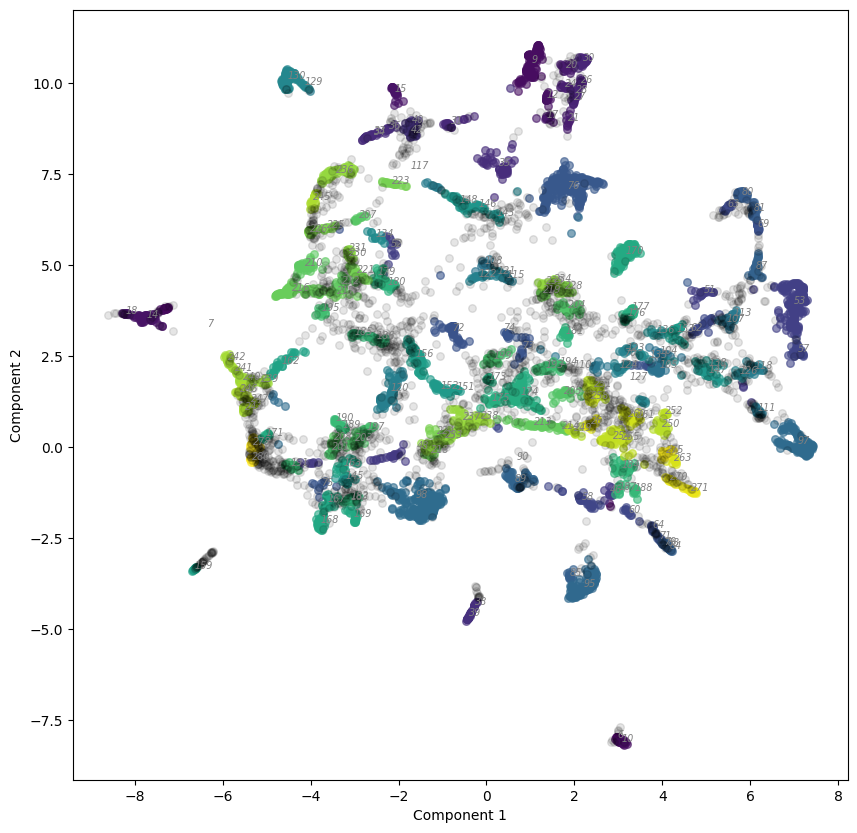

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k in range(2, n_clusters):
    # NOTE: ignore coi=1 for viz (outlier)
    # if k == 1: continue

    idx = np.where(hdbs.labels_ == k)[0]

    if len(idx) < 10:
        continue
    
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k, color='gray', fontsize='x-small', fontstyle='italic')

# plot uncategorized
idx = np.where(hdbs.labels_ == -1)[0]
ax.scatter(Cu2d[idx, 0], Cu2d[idx, 1], s=30, c='k', alpha=0.1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

# ax.set_xlim([0,20])

plt.show()

# testing drift

In [26]:
from scipy.stats import f
def hotelling_t2_test(X, mu0=None):
    """
    Conduct a one-sample Hotelling T^2 test for the hypothesis H0: E[X] = mu0.
    
    Parameters
    ----------
    X : (n, d) array-like
        The sample data. Each row is an observation in R^d.
    mu0 : (d,) array-like or None
        The hypothesized mean vector. If None, tests against a zero vector.
        
    Returns
    -------
    T2_stat : float
        The Hotelling T^2 statistic.
    F_stat : float
        The equivalent F-statistic.
    p_value : float
        The p-value from the F-distribution.
    """
    X = np.asarray(X, dtype=float)
    n, d = X.shape
    
    if mu0 is None:
        mu0 = np.zeros(d)
    else:
        mu0 = np.asarray(mu0, dtype=float)
        if mu0.shape != (d,):
            raise ValueError("mu0 must be of shape (d,).")
    
    # Sample mean
    X_bar = X.mean(axis=0)

    # Sample covariance (unbiased) and inverse
    S = np.cov(X, rowvar=False)  # shape (d, d)
    # Might need a pseudo-inverse if S is singular in high dimensions
    S_inv = np.linalg.inv(S)
    
    # Hotelling T^2
    diff = X_bar - mu0
    T2_stat = n * diff @ S_inv @ diff
    
    # Convert to F-statistic
    # F ~ F(d, n-d) under H0
    F_stat = ((n - d) / (d * (n - 1))) * T2_stat
    
    # p-value
    p_value = 1 - f.cdf(F_stat, d, n - d)
    
    return T2_stat, F_stat, p_value

In [35]:
# test Hotelling T2 on RW w/ drift

d = 10
n = 50
wt = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)
print(wt.shape)
walk = np.cumsum(wt)
t2, fs, pv = hotelling_t2_test(wt, mu0=np.zeros(d))
print(f'{t2:.3f} - {fs:.3f} - {pv:.5f}')

(50, 10)
9.766 - 0.797 - 0.63188


In [31]:
for coi in np.unique(hdbs.labels_):
    if coi == -1:
        continue
    
    idx = np.where(hdbs.labels_ == coi)[0]
    if len(idx) < 5:
        continue

    # get time diffs
    cmx = Cu[idx,:]
    diffs = cmx[1:,:] - cmx[:-1,:]

    # compute Hotelling T^2 test
    try:
        t2, fs, pv = hotelling_t2_test(diffs)
        print(f'{coi} ({len(idx)}): {t2:.3f} - {fs:.3f} - {pv:.5f}')
    except:
        print(f'{coi}: error')

0: error
1: error
2: error
3 (8): 6385951365640.425 - -319297568282.021 - nan
4 (7): -16672053841265.234 - 1333764307301.219 - nan
5 (5): -182897800561508800.000 - 36579560112301760.000 - nan
6 (11): 147523496509.220 - 0.000 - nan
7 (21): 1.597 - 0.084 - 0.99973
8: error
9 (111): 0.309 - 0.028 - 1.00000
10 (22): 1.954 - 0.107 - 0.99929
11 (5): -36309618755579472.000 - 7261923751115895.000 - nan
12 (17): 2.253 - 0.090 - 0.99937
13 (7): 3509479719975.049 - -280758377598.004 - nan
14 (50): 0.552 - 0.045 - 0.99999
15 (44): 0.104 - 0.008 - 1.00000
16 (9): 241855858077.985 - -6910167373.657 - nan
17 (11): -32628286359.193 - -0.000 - nan
18 (12): 33.677 - 0.337 - 0.88442
19: error
20 (20): 3.183 - 0.159 - 0.99589
21 (10): -356433246166.732 - 4455415577.084 - nan
22 (9): 27023059460218.641 - -772087413149.104 - nan
23 (8): -25163770124137.375 - 1258188506206.869 - nan
24 (12): 6.512 - 0.065 - 0.99713
25 (5): 187284917750947.312 - -37456983550189.461 - nan
26 (16): 0.581 - 0.021 - 1.00000
27 (1

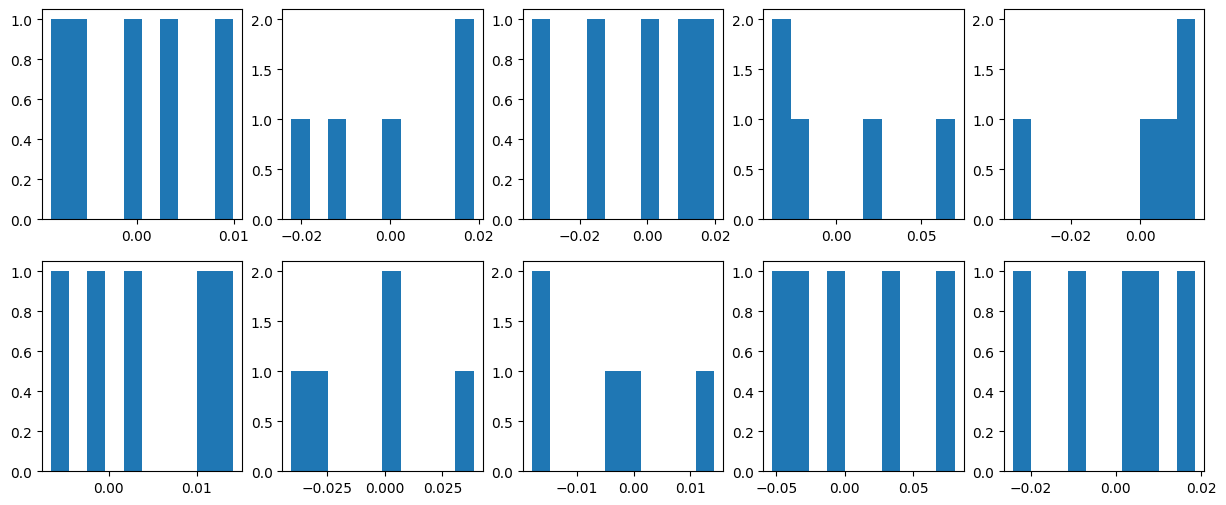

In [36]:
fig, axs = plt.subplots(2,5, figsize=(15,6))
for i, ax in enumerate(axs.ravel()):
    ax.hist(diffs[:,i])

In [37]:
from sklearn.decomposition import PCA

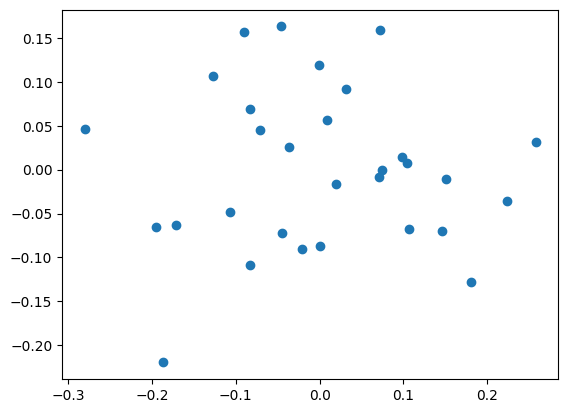

In [38]:
coi = 162

idx = np.where(hdbs.labels_ == coi)[0]
cmx = C[idx,:]
diffs = cmx[1:,:] - cmx[:-1,:]

diffs_pca = PCA(n_components=2).fit_transform(diffs)

plt.scatter(diffs_pca[:,0], diffs_pca[:,1])

# plotting drift

/local/scr/stmorse/TMPDIR/ipykernel_2191330/3584442266.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[coi], alpha=0.6, label=k)


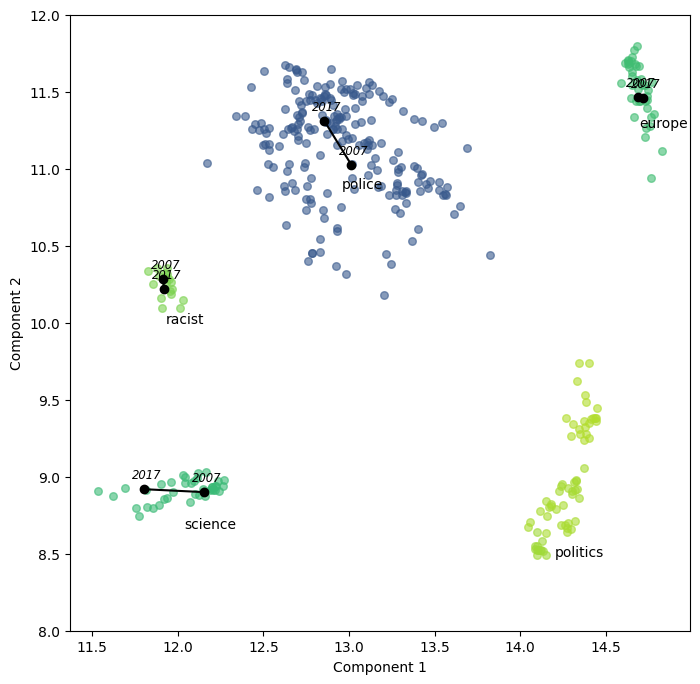

In [54]:
cois = [214, 217, 218, 221, 169, 69, 173, 201]
hlabels = [' ', ' ', 'politics', ' ', 'science', 'police', 'europe', 'racist']

fig, ax = plt.subplots(1,1, figsize=(8,8))

# use the same colors as full plot
n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

N = len(years)

for i, coi in enumerate(cois):
    idx = np.where(hdbs.labels_ == coi)[0]

    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[coi], alpha=0.6, label=k)

    if coi in [169, 69, 173, 201]:
        annual_avgs = []
        for y in [0, N-1]:
        # for y in range(N):
            # indices split marks
            # NOTE: assumes Ck=50 and 12 non-overlapping month-windows
            split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

            # get just indices in this year
            sub = idx[np.where((idx >= split_0) & (idx < split_1))[0]]

            # if empty, skip
            if len(sub) == 0:
                continue

            # get average position in this year
            avg = np.mean(Cu2d[sub,:], axis=0)
            ax.text(avg[0] - 0.07, avg[1] + 0.07, years[y], fontstyle='italic', fontsize='small')
            annual_avgs.append(avg)
        annual_avgs = np.vstack(annual_avgs)

        ax.plot(annual_avgs[:,0], annual_avgs[:,1], 'ko-')
        
    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1] - 0.25, hlabels[i])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

ax.set_ylim([8,12])
# ax.set_xlim([11,15])

plt.show()

In [12]:
coi = 225

idx = np.where(hdbs.labels_ == coi)[0]
for x in idx:
    print(f'{x} ({x // 50}) ({hdbs.probabilities_[x]:.3f}): {T[x][:5]}')

7 (0) (1.000): ['belief' 'religion' 'religious' 'evidence' 'dawkins']
92 (1) (1.000): ['religion' 'religious' 'islam' 'christian' 'christianity']
110 (2) (1.000): ['atheists' 'religion' 'atheism' 'religious' 'atheist']
194 (3) (1.000): ['christians' 'christian' 'christianity' 'religion' 'homosexuality']
229 (4) (1.000): ['jesus' 'christ' 'shall' 'bible' 'gospels']
239 (4) (1.000): ['religion' 'christians' 'atheists' 'christian' 'atheism']
254 (5) (1.000): ['atheist' 'jesus' 'faith' 'christian' 'bible']
262 (5) (0.994): ['religion' 'belief' 'faith' 'beliefs' 'scientific']
297 (5) (1.000): ['bible' 'jesus' 'christians' 'christian' 'testament']
335 (6) (1.000): ['religion' 'religions' 'atheists' 'beliefs' 'enlightenment']
344 (6) (0.712): ['atheist' 'atheists' 'religion' 'atheism' 'christian']
389 (7) (0.916): ['religion' 'christians' 'christian' 'religious' 'church']
395 (7) (0.797): ['atheists' 'religion' 'atheism' 'atheist' 'beliefs']
413 (8) (1.000): ['religion' 'beliefs' 'dawkins' 'a

In [16]:
# cois = [183, 188, 189, 153, 191]
cois = np.arange(np.amax(hdbs.labels_))

for coi in cois:
    idx = np.where(hdbs.labels_ == coi)[0]
    
    if len(idx) < 6: 
        continue

    all_words = []
    for x in idx:
        all_words.extend(T[x][:10])
    
    # Count the frequency of each word
    word_counts = Counter(all_words)

    # Find the most common word
    common = word_counts.most_common(3)
    s_common = ' '.join([f'"{word}" ({count})' for word, count in common])

    print(f'{coi}: {s_common}')

0: "megusta" (9) "ohcrap" (8) "twismug" (8)
1: "number" (25) "numbers" (16) "math" (10)
2: "de" (39) "en" (32) "la" (26)
3: "food" (7) "store" (6) "beer" (6)
4: "join" (13) "pm" (11) "send" (8)
5: "maps" (5) "area" (4) "spn" (3)
6: "meet" (5) "downtown" (5) "weekend" (5)
7: "books" (33) "book" (33) "writing" (24)
8: "hour" (17) "weekend" (15) "friday" (12)
9: "release" (6) "date" (5) "announced" (5)
10: "added" (7) "eternity" (3) "eternal" (3)
11: "steamcommunity" (7) "pm" (6) "sent" (5)
12: "hunter" (7) "psn" (6) "warlock" (6)
13: "added" (20) "31" (12) "ign" (8)
14: "psn" (5) "painted" (4) "messaged" (3)
16: "area" (9) "moving" (9) "city" (9)
17: "area" (6) "city" (5) "places" (5)
18: "jobs" (6) "career" (5) "pay" (4)
20: "college" (47) "school" (29) "classes" (27)
21: "learning" (9) "learn" (8) "practice" (5)
22: "area" (10) "city" (8) "drive" (6)
23: "area" (8) "drive" (7) "driving" (6)
24: "food" (5) "city" (5) "places" (5)
25: "area" (32) "city" (31) "moving" (24)
26: "diet" (6) 

In [29]:
# CHECK ANNUAL CHANGE IN PAIRWISE DISTANCE 

labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 15]
n = len(labels_trim)
N = len(years)

# diffs holds the dist in year_i between group_j and group_k
# NOTE: upper triangular bc dist is symmetric
# (year, label, label)
diffs = np.nan * np.ones((N, n, n))
for y in range(N):
    # indices split marks
    # NOTE: assumes Ck=50 and 12 non-overlapping month-windows
    split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

    # loop cluster of row
    for xa in range(n):
        # get label number
        coi_a = labels_trim[xa]

        # all indices within C
        idx_a = np.where(hdbs.labels_==coi_a)[0]

        # get just indices in this year
        sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]

        # loop cluster of column
        for xb in range(xa, n):
            coi_b = labels_trim[xb]
            idx_b = np.where(hdbs.labels_==coi_b)[0]
            sub_b = idx_b[np.where((idx_b >= split_0) & (idx_b < split_1))[0]]

            # if either cluster is empty this year, skip
            if len(sub_a) == 0 or len(sub_b) == 0:
                diffs[y,xa,xb] = np.nan
                continue

            # compute average centroid
            avg_a = np.mean(C[sub_a], axis=0)
            avg_b = np.mean(C[sub_b], axis=0)

            # compute difference
            diff = np.linalg.norm(avg_a - avg_b)
            diffs[y,xa,xb] = diff

# compute change in distance from year_i to year_i+1
change = diffs[1:,:,:] - diffs[:-1,:,:]
print(change.shape)

(10, 101, 101)


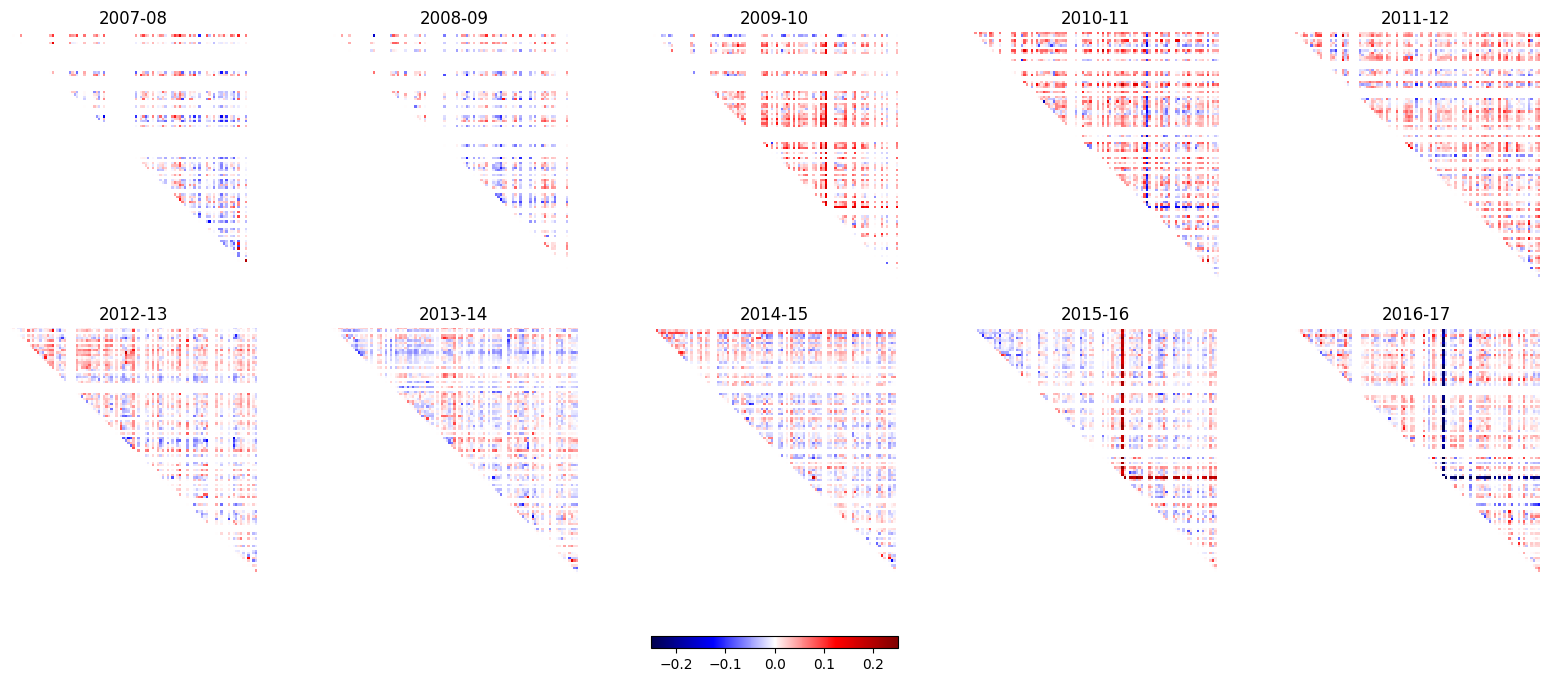

In [30]:
fig, axs = plt.subplots(2,5, figsize=(20,8))

titles = [f'{years[y]}-{str(years[y+1])[-2:]}' for y in range(len(years)-1)]
for i, ax in enumerate(axs.ravel()):
    cb = ax.imshow(change[i,:,:], 
                 cmap='seismic', interpolation='none',
                 vmin=-0.25, vmax=0.25)
    
    ax.axis('off')
    ax.set_title(titles[i])

fig.colorbar(cb, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
# plt.tight_layout()
plt.show()

In [37]:
yi = np.where(change[8,5,:] > 0.05)
yi

(array([61, 72]),)

In [39]:
labels_trim[72]

np.int64(181)

In [39]:
labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 100]
n = len(labels_trim)
P = len(years) * 12

# will hold the counts of cluster n in period p
M = np.zeros((P, n))
for j, coi in enumerate(labels_trim):
    for p in range(P):
        split_0, split_1 = p * 50, (p+1) * 50
        idx = np.where(hdbs.labels_ == coi)[0]
        sub = idx[np.where((idx >= split_0) & (idx < split_1))[0]]
        M[p,j] = len(sub)

M.shape

(120, 4)

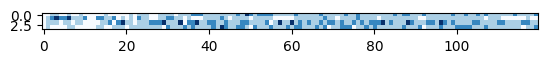

In [41]:
fig, ax = plt.subplots(1,1)
ax.imshow(M.T, cmap='Blues')